# GDPR Violation Decision Tree Model

A Jupyter Notebook for Predicting and Explaining GDPR Violations Using Decision Tree Algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import os

In [2]:
np.random.seed(42)

# Step 1: Data Loading and Preprocessing

In [3]:
# Load data
file_path = "FINALFI.csv"
df = pd.read_csv(file_path, sep=";")

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# Check data types
print("\nData types:")
print(df.dtypes)

# Preview the first 5 rows
print("\nData preview:")
df.head()

Dataset shape: (2412, 27)
Dataset columns: ['Affected_data_volume', 'Criminal_investigation_exception', 'Date', 'company_industry', 'country', 'country_security_exception', 'data_category_Basic_personal_data', 'data_category_Children_data', 'data_category_Criminal_data', 'data-category_Financial_data', 'data_category_location_data', 'data_category_Special_category_data', 'data_processing_basis_Consent', 'data_processing_basis_Legal_obligation', 'data_processing_basis_Legitimate_interest', 'data_processing_basis_Performance_of_public_task', 'data_processing_basis_Protection_of_vital_interests', 'data_processing_basis_contract_performance', 'fine_amount', 'free_speech_exception', 'gdpr_clause', 'gdpr_conflict', 'violation_nature_Breach_of_Data_processing_principle', 'violation_nature_Breach_of_data_security', 'violation_nature_Violation_of_Data_processing_obligation', 'violation_nature_Violation_of_data_subject_rights', 'violation_result']

Data types:
Affected_data_volume               

,Affected_data_volume,Criminal_investigation_exception,Date,company_industry,country,country_security_exception,data_category_Basic_personal_data,data_category_Children_data,data_category_Criminal_data,data-category_Financial_data,...,data_processing_basis_contract_performance,fine_amount,free_speech_exception,gdpr_clause,gdpr_conflict,violation_nature_Breach_of_Data_processing_principle,violation_nature_Breach_of_data_security,violation_nature_Violation_of_Data_processing_obligation,violation_nature_Violation_of_data_subject_rights,violation_result
0,unspecific,0,2020,Education,Netherlands,0,1,0,0,0,...,0,0,0,Article 6(1)(e),No conflict,0,0,0,0,0
1,unspecific,0,2020,Public sector,Estonia,0,1,0,1,0,...,0,0,0,Article 58(2)(g),No conflict,0,0,0,1,1
2,unspecific,0,2019,Marketing,Spain,0,1,0,0,0,...,0,6000,0,Article 6.1,No conflict,1,0,0,0,1
3,1500000,0,2023,Medical,France,0,1,0,0,0,...,0,0,0,"Article 6.1.e, Article 9.2.j",No conflict,0,0,0,0,0
4,unspecific,0,2019,Retail,Portugal,0,1,0,0,0,...,0,200000,0,Article 13,No conflict,1,0,0,1,1


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values summary:\n{missing_values[missing_values > 0]}")

# Handle missing values (if any)
if missing_values.sum() > 0:
    print("Handling missing values...")
    # Fill numeric columns with 0 and categorical columns with the mode
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df[col].mode()[0])


Missing values summary:
Series([], dtype: int64)


In [5]:
# %%
# Process the Affected_data_volume column (convert 'unspecific' to 0)
if 'Affected_data_volume' in df.columns:
    print("Original Affected_data_volume value distribution:")
    print(df['Affected_data_volume'].value_counts().head())
    
    # Check data type
    print(f"\nAffected_data_volume data type: {df['Affected_data_volume'].dtype}")
    
    # Convert 'unspecific' to 0
    if df['Affected_data_volume'].dtype == 'object':
        df['Affected_data_volume'] = pd.to_numeric(df['Affected_data_volume'].replace('unspecific', 0), errors='coerce').fillna(0)
        print("\nConverted Affected_data_volume value distribution:")
        print(df['Affected_data_volume'].value_counts().head())


Original Affected_data_volume value distribution:
unspecific    1977
1               22
2                8
1500000          6
1000000          6
Name: Affected_data_volume, dtype: int64

Affected_data_volume data type: object

Converted Affected_data_volume value distribution:
0          1977
1            22
2             8
1500000       6
1000000       6
Name: Affected_data_volume, dtype: int64


In [6]:
# %%
# Process categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical features: {categorical_columns.tolist()}")

# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    if col not in ['gdpr_clause']:  # Exclude complex text fields
        print(f"Label encoding column '{col}'")
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Processed data preview
print("\nPreview of encoded data:")
df.head()

Categorical features: ['Date', 'company_industry', 'country', 'fine_amount', 'gdpr_clause', 'gdpr_conflict']
Label encoding column 'Date'
Label encoding column 'company_industry'
Label encoding column 'country'
Label encoding column 'fine_amount'
Label encoding column 'gdpr_conflict'

Preview of encoded data:


,Affected_data_volume,Criminal_investigation_exception,Date,company_industry,country,country_security_exception,data_category_Basic_personal_data,data_category_Children_data,data_category_Criminal_data,data-category_Financial_data,...,data_processing_basis_contract_performance,fine_amount,free_speech_exception,gdpr_clause,gdpr_conflict,violation_nature_Breach_of_Data_processing_principle,violation_nature_Breach_of_data_security,violation_nature_Violation_of_Data_processing_obligation,violation_nature_Violation_of_data_subject_rights,violation_result
0,0,0,4,0,23,0,1,0,0,0,...,0,0,0,Article 6(1)(e),0,0,0,0,0,0
1,0,0,4,8,8,0,1,0,1,0,...,0,0,0,Article 58(2)(g),0,0,0,0,1,1
2,0,0,3,6,30,0,1,0,0,0,...,0,217,0,Article 6.1,0,1,0,0,0,1
3,1500000,0,7,7,11,0,1,0,0,0,...,0,0,0,"Article 6.1.e, Article 9.2.j",0,0,0,0,0,0
4,0,0,3,9,27,0,1,0,0,0,...,0,94,0,Article 13,0,1,0,0,1,1


# Step 2. Exploratory Data Analysis

Target variable 'violation_result' distribution:
1    2058
0     354
Name: violation_result, dtype: int64
Violation rate: 85.32%


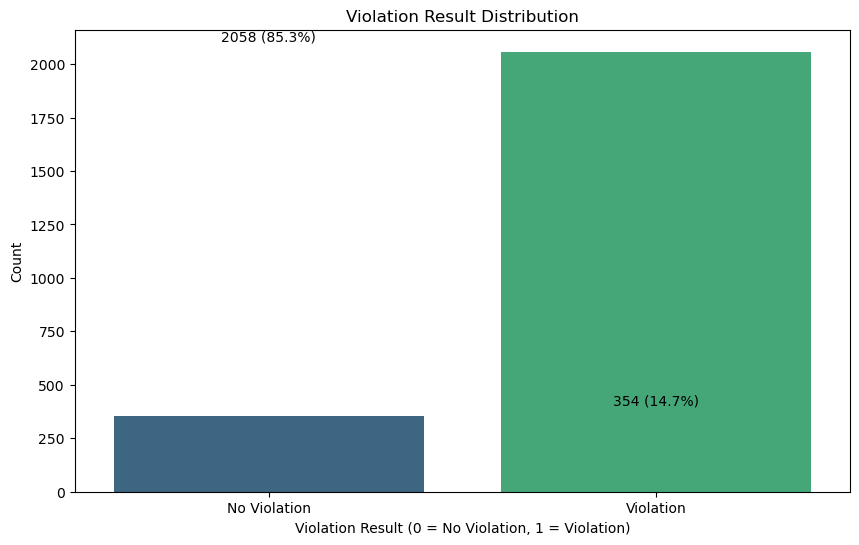

In [7]:
# %%
# View target variable distribution
print("Target variable 'violation_result' distribution:")
violation_result_counts = df['violation_result'].value_counts()
print(violation_result_counts)
print(f"Violation rate: {violation_result_counts[1] / len(df) * 100:.2f}%")

# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='violation_result', data=df, palette='viridis')
plt.title('Violation Result Distribution')
plt.xlabel('Violation Result (0 = No Violation, 1 = Violation)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Violation', 'Violation'])
for i, count in enumerate(violation_result_counts.values):
    plt.text(i, count + 50, f'{count} ({count/len(df)*100:.1f}%)', ha='center')
plt.show()

Violation Nature Distribution:
violation_nature_Breach_of_Data_processing_principle: 1429 (59.25%)
violation_nature_Breach_of_data_security: 464 (19.24%)
violation_nature_Violation_of_Data_processing_obligation: 842 (34.91%)
violation_nature_Violation_of_data_subject_rights: 1418 (58.79%)


<Figure size 1400x800 with 0 Axes>

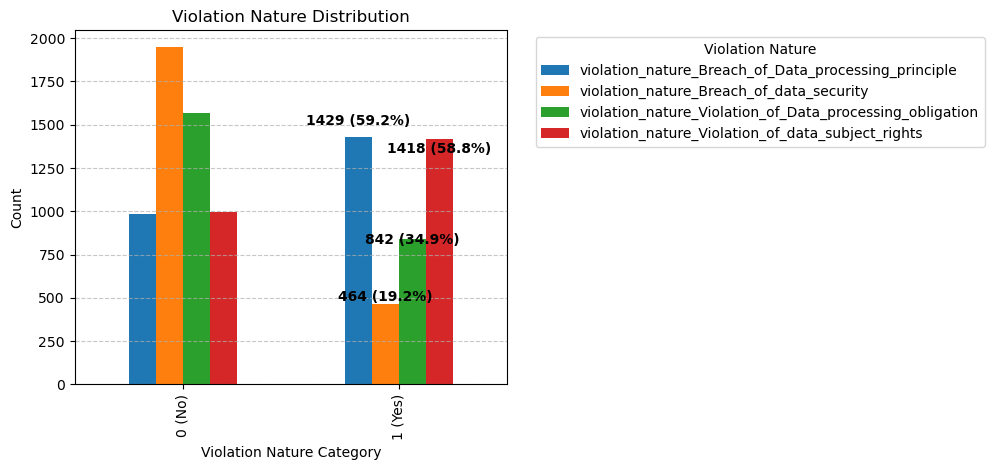

In [8]:

# View distribution of violation_nature related variables
violation_nature_cols = [col for col in df.columns if col.startswith('violation_nature_')]
if violation_nature_cols:
    print("Violation Nature Distribution:")
    
    # Create a DataFrame to store distributions
    nature_distribution = pd.DataFrame()
    
    for col in violation_nature_cols:
        positive_count = df[col].sum()
        negative_count = len(df) - positive_count
        
        nature_distribution[col] = [negative_count, positive_count]
        
        print(f"{col}: {positive_count} ({positive_count / len(df) * 100:.2f}%)")
    
    # Set index
    nature_distribution.index = ['0 (No)', '1 (Yes)']
    
    # Visualization
    plt.figure(figsize=(14, 8))
    ax = nature_distribution.plot(kind='bar', stacked=False)
    plt.title('Violation Nature Distribution')
    plt.xlabel('Violation Nature Category')
    plt.ylabel('Count')
    
    # 将图例放到图表区域外的右侧
    plt.legend(title='Violation Nature', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 垂直错开标签以避免重叠
    y_offsets = [50, 0, -50, -100]  # 不同的垂直偏移量
    
    # Add value labels with vertical offsets to avoid overlap
    for i, container in enumerate(ax.containers):
        for j, val in enumerate(container):
            # Only label the "Yes" category (index 1)
            if j == 1:  # This corresponds to '1 (Yes)' row
                height = val.get_height()
                count = nature_distribution.iloc[j, i]
                percentage = count / len(df) * 100
                
                # 使用不同的垂直偏移，避免标签重叠
                y_offset = y_offsets[i % len(y_offsets)]
                
                ax.text(
                    val.get_x() + val.get_width()/2, 
                    height + 20 + y_offset,  # 使用不同的垂直偏移
                    f'{int(count)} ({percentage:.1f}%)', 
                    ha='center',
                    fontweight='bold'
                )
    
    # 调整布局以适应右侧图例
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)  # 给右侧的图例留出空间
    plt.show()

Calculating correlation matrix...

Features most correlated with violation_result:
violation_result                                            1.000000
violation_nature_Breach_of_Data_processing_principle        0.414221
violation_nature_Violation_of_data_subject_rights           0.304944
violation_nature_Violation_of_Data_processing_obligation    0.286524
violation_nature_Breach_of_data_security                    0.175664
fine_amount                                                 0.170394
gdpr_conflict                                               0.168974
country                                                     0.090242
data_processing_basis_Consent                               0.072670
Date                                                        0.066934
data_category_Special_category_data                         0.024713
Name: violation_result, dtype: float64

Features most correlated with fine_amount:
fine_amount                                                 1.000000
violat

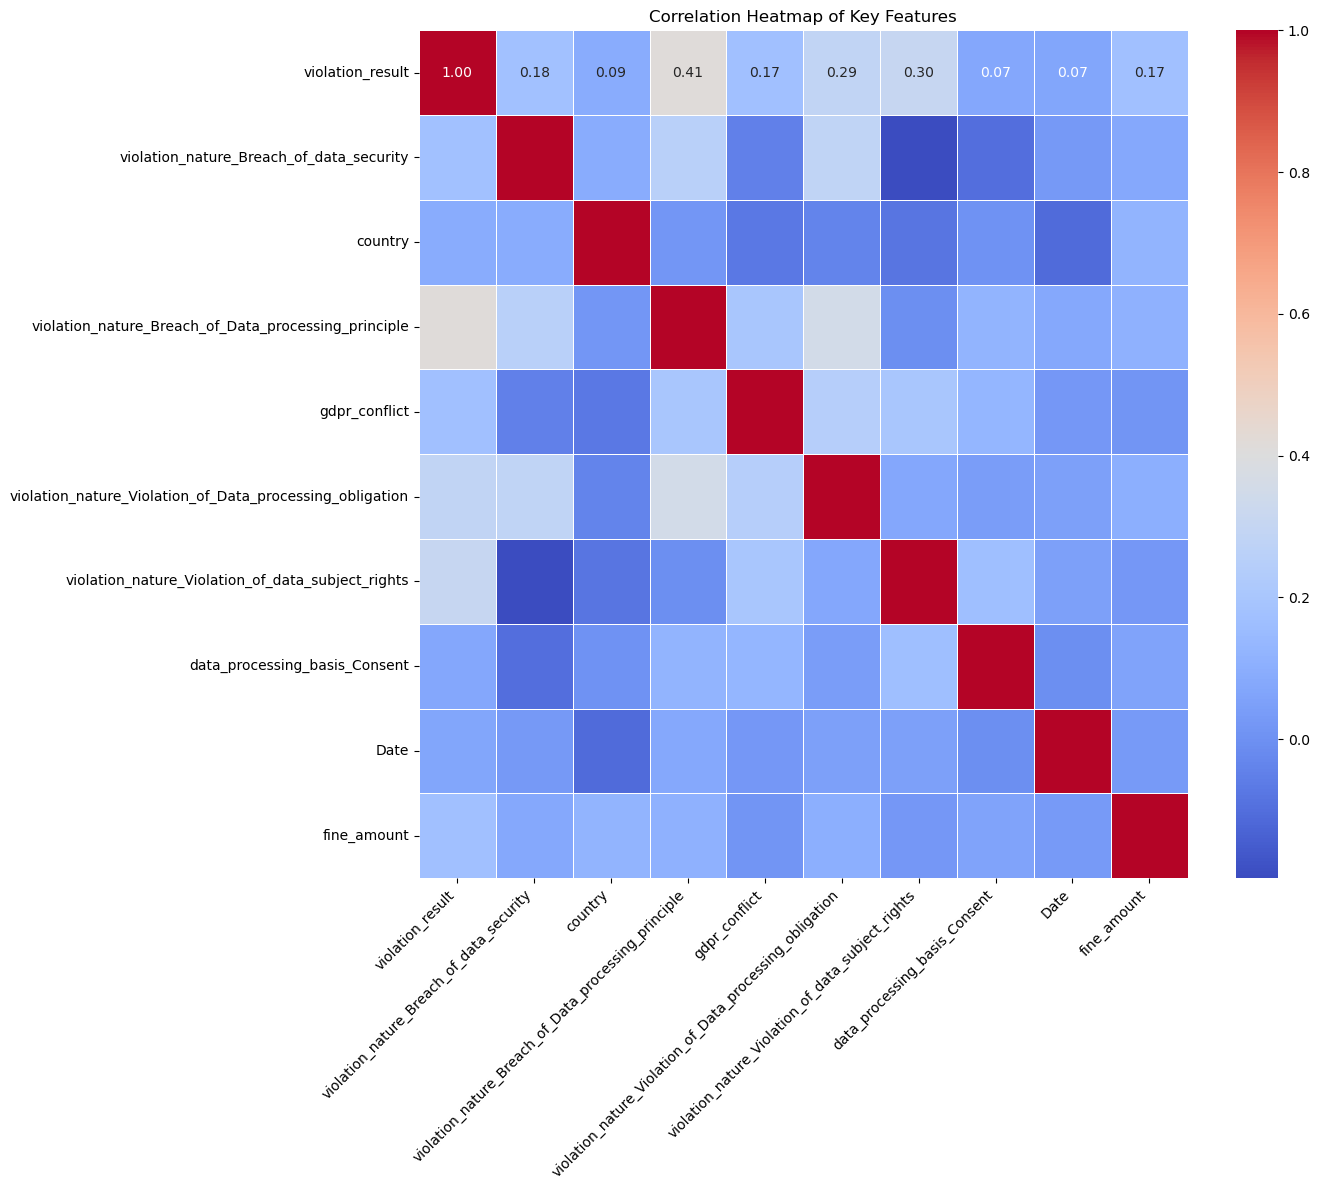

In [9]:
# %%
# Correlation analysis
print("Calculating correlation matrix...")
# Select numeric variables
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()

# Output top 10 features most correlated with the target variable
if 'violation_result' in correlation:
    violation_result_corr = correlation['violation_result'].sort_values(ascending=False)
    print("\nFeatures most correlated with violation_result:")
    print(violation_result_corr.head(11))  # Including itself

if 'fine_amount' in correlation:
    fine_amount_corr = correlation['fine_amount'].sort_values(ascending=False)
    print("\nFeatures most correlated with fine_amount:")
    print(fine_amount_corr.head(11))  # Including itself

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
# Get the top 15 most correlated features
top_features = set()
if 'violation_result' in correlation:
    top_features.update(violation_result_corr.head(8).index)
if 'fine_amount' in correlation:
    top_features.update(fine_amount_corr.head(8).index)

# Add target variables
target_vars = ['violation_result', 'fine_amount']
for col in target_vars:
    if col in correlation.columns:
        top_features.add(col)

for col in violation_nature_cols:
    if col in correlation.columns:
        top_features.add(col)

# Plot heatmap
sns.heatmap(correlation.loc[list(top_features), list(top_features)], 
           annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Step 3. Feature Selection

In [10]:
# Select features and target variables for the model
# Exclude target variables and unrelated features
exclude_columns = ['violation_result', 'fine_amount']
exclude_columns.extend([col for col in df.columns if col.startswith('violation_nature_')])

# For high cardinality text features like gdpr_clause, we may need to exclude them
if 'gdpr_clause' in df.columns:
    exclude_columns.append('gdpr_clause')

# Feature matrix
X = df.drop(exclude_columns, axis=1)
print(f"Number of selected features: {X.shape[1]}")
print(f"Feature list: {X.columns.tolist()}")

# Target variable: violation_result
y_violation = df['violation_result']
print(f"\nViolation Result label distribution: {y_violation.value_counts().to_dict()}")

# Target variable: violation_nature_*
violation_nature_cols = [col for col in df.columns if col.startswith('violation_nature_')]
y_nature_dict = {}
for col in violation_nature_cols:
    y_nature_dict[col] = df[col]
    print(f"{col} label distribution: {df[col].value_counts().to_dict()}")

# Target variable: fine_amount
y_fine = df['fine_amount']
print(f"\nFine Amount range: {y_fine.min()} - {y_fine.max()}")


Number of selected features: 20
Feature list: ['Affected_data_volume', 'Criminal_investigation_exception', 'Date', 'company_industry', 'country', 'country_security_exception', 'data_category_Basic_personal_data', 'data_category_Children_data', 'data_category_Criminal_data', 'data-category_Financial_data', 'data_category_location_data', 'data_category_Special_category_data', 'data_processing_basis_Consent', 'data_processing_basis_Legal_obligation', 'data_processing_basis_Legitimate_interest', 'data_processing_basis_Performance_of_public_task', 'data_processing_basis_Protection_of_vital_interests', 'data_processing_basis_contract_performance', 'free_speech_exception', 'gdpr_conflict']

Violation Result label distribution: {1: 2058, 0: 354}
violation_nature_Breach_of_Data_processing_principle label distribution: {1: 1429, 0: 983}
violation_nature_Breach_of_data_security label distribution: {0: 1948, 1: 464}
violation_nature_Violation_of_Data_processing_obligation label distribution: {0: 1

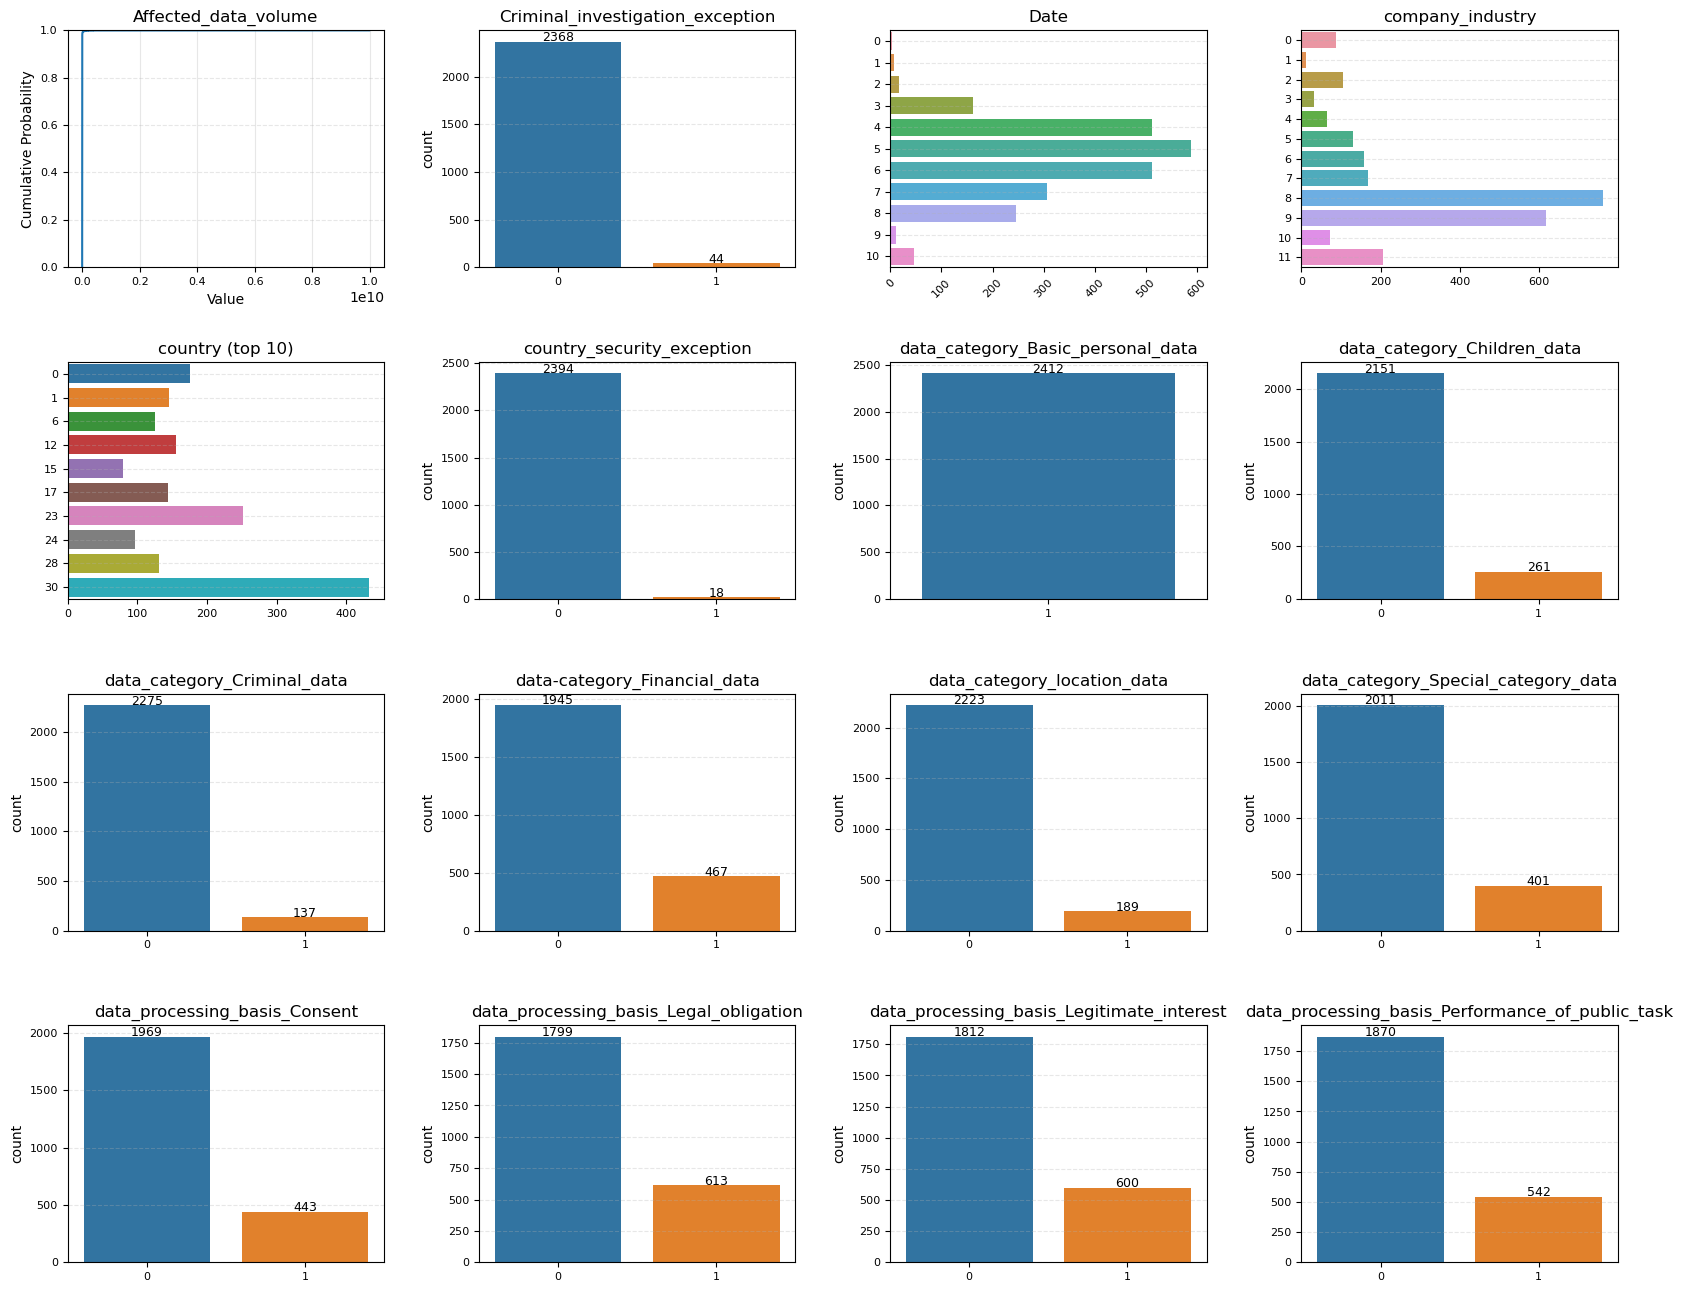

In [11]:
# View feature distribution with improved readability
plt.figure(figsize=(20, 16))  # Increase overall chart size

for i, col in enumerate(X.columns[:min(16, len(X.columns))]):
    ax = plt.subplot(4, 4, i+1)
    
    if col == 'Affected_data_volume':
        # Use CDF plot for Affected_data_volume
        sns.ecdfplot(x=X[col], ax=ax)
        plt.title(col, fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Cumulative Probability')
        # Add grid for better readability
        plt.grid(True, alpha=0.3)
        
    elif X[col].dtype in ['int64', 'int32', 'bool']:
        # For categorical variables, use countplot
        if col == 'country':
            # Special handling for country column as it has too many categories
            # Only display top 10 countries by count
            top_countries = X[col].value_counts().nlargest(10).index
            sns.countplot(y=col, data=X[X[col].isin(top_countries)])
            plt.title(f"{col} (top 10)", fontsize=12)
            plt.ylabel('')
        elif col == 'company_industry' or X[col].nunique() > 10:
            # For variables with multiple categories, use vertical bar chart and rotate labels
            ax = sns.countplot(y=col, data=X)
            plt.title(col, fontsize=12)
            plt.ylabel('')
        else:
            # For variables with fewer categories, use horizontal bar chart
            ax = sns.countplot(x=col, data=X)
            # Add count labels to each bar
            for p in ax.patches:
                height = p.get_height()
                if height > 0:  # Only add labels when height is greater than 0
                    ax.text(p.get_x() + p.get_width()/2, height + 5, 
                            f'{int(height)}', ha='center', fontsize=9)
            plt.title(col, fontsize=12)
            
    else:
        # For continuous variables, use histplot
        sns.histplot(X[col], kde=True)
        plt.title(col, fontsize=12)
    
    # Improve readability of x-axis labels
    if col == 'Date':
        plt.xticks(rotation=45, fontsize=8)
    elif plt.gca().get_xlabel() != '':  # Only adjust when x-axis has labels
        plt.xticks(fontsize=8)
        
    # Adjust y-axis for better readability
    plt.yticks(fontsize=8)
    
    # Keep x and y labels for CDF plot, remove for others
    if col != 'Affected_data_volume':
        plt.xlabel('')
    
    # Add grid lines to improve readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

# Step 4. Model Training

## 4.1 K-fold split

In [12]:
# %%
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Select features and target variables for the model
def preprocess_data(df):
    exclude_columns = ['violation_result', 'fine_amount']
    exclude_columns.extend([col for col in df.columns if col.startswith('violation_nature_')])

    # For high cardinality text features like gdpr_clause, we may need to exclude them
    if 'gdpr_clause' in df.columns:
        exclude_columns.append('gdpr_clause')

    # Feature matrix: Removing unwanted columns
    X = df.drop(exclude_columns, axis=1)
    y = df['violation_result']  # Target variable: violation_result
    return X, y

# K-Fold Cross-Validation function
def evaluate_model_kfold(df, model, n_splits=5):
    X, y = preprocess_data(df)
    
    # Define StratifiedKFold cross-validator
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    print(f"Training baseline model with {n_splits}-Fold Cross-Validation...\n")

    # Perform K-Fold Cross-Validation
    for fold, (train_index, val_index) in enumerate(kf.split(X, y), 1):
        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        fold_accuracies.append(accuracy)
        print(f" Fold {fold}: Accuracy = {accuracy:.4f}")

    # Calculate average accuracy across folds
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"\nAverage Cross-Validated Accuracy: {avg_accuracy:.4f}")
    return avg_accuracy


In [13]:
# 1. **Baseline Model**
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_baseline_model(df):
    # Preprocess the data
    X, y = preprocess_data(df)
    
    # Initialize and train the Decision Tree model
    baseline_classifier = DecisionTreeClassifier(random_state=42)
    baseline_classifier.fit(X, y)
    
    # Evaluate the model on the full dataset (just for a baseline score, typically we use a validation set here)
    y_pred = baseline_classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"Baseline model accuracy: {accuracy:.4f}")
    return baseline_classifier, accuracy

In [14]:
model = DecisionTreeClassifier(random_state=42)
evaluate_model_kfold(df, model, n_splits=5)

Training baseline model with 5-Fold Cross-Validation...

 Fold 1: Accuracy = 0.8054
 Fold 2: Accuracy = 0.8178
 Fold 3: Accuracy = 0.7946
 Fold 4: Accuracy = 0.8050
 Fold 5: Accuracy = 0.7759

Average Cross-Validated Accuracy: 0.7997


0.7997414155992543

In [15]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score

# Function to perform Nested Cross-Validation with hyperparameter tuning
def nested_cross_validation(df, n_splits=5):
    # Preprocess the data
    X, y = preprocess_data(df)

    # Define outer and inner cross-validation
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_macro_scorer = make_scorer(f1_score, average='macro')
    balanced_acc_scorer = make_scorer(balanced_accuracy_score)
    # New hyperparameter grid for tuning
    param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],  
    'min_samples_split': [2, 5, 10, 15, 20, 30],       
    'min_samples_leaf': [1, 2, 4, 8, 16],              
    'criterion': ['gini', 'entropy'],                  
    'splitter': ['best', 'random'],                    
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]   
}

    
    # Store results for each fold
    outer_accuracies = []

    print(f"Performing Nested Cross-Validation with hyperparameter tuning...\n")

    # Outer cross-validation loop
    for fold, (train_index, val_index) in enumerate(outer_cv.split(X, y), 1):
        # Split data into training and validation sets for outer fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Inner cross-validation for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        model = DecisionTreeClassifier(random_state=42)
        
        # GridSearchCV for hyperparameter tuning (inner loop)
        grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring=f1_macro_scorer, return_train_score=True, verbose=1)
        
        # Fit the model on the inner cross-validation training data
        grid_search.fit(X_train, y_train)

        # Best model from inner cross-validation
        best_model = grid_search.best_estimator_

        # Evaluate the best model on the outer validation set
        y_pred = best_model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        # Store the accuracy for the current fold
        outer_accuracies.append(accuracy)
        print(f" Fold {fold}: Outer Accuracy = {accuracy:.4f}, Best Params = {grid_search.best_params_}")

    # Return all outer fold accuracies for comparison
    return outer_accuracies

# Example usage
accuracies = nested_cross_validation(df, n_splits=5)

# Print accuracies for each fold
print(f"\nAccuracies for each fold: {accuracies}")

Performing Nested Cross-Validation with hyperparameter tuning...

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
 Fold 1: Outer Accuracy = 0.7847, Best Params = {'criterion': 'entropy', 'max_depth': 25, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
 Fold 2: Outer Accuracy = 0.8364, Best Params = {'criterion': 'entropy', 'max_depth': 25, 'max_features': 0.7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
 Fold 3: Outer Accuracy = 0.8257, Best Params = {'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 15, 'splitter': 'best'}
Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
 Fold 4: Outer Accuracy = 0.8071, Best Params = {'criterion': 'gini', 'max_depth': 25, 'max_features': 0.7, 'min_samples_leaf': 1, 'mi

### Final Model

In [16]:

exclude_columns = ['violation_result', 'fine_amount']
exclude_columns.extend([col for col in df.columns if col.startswith('violation_nature_')])
if 'gdpr_clause' in df.columns:
    exclude_columns.append('gdpr_clause')

X_full = df.drop(columns=exclude_columns)

y_full = df['violation_result']


In [17]:
print(f"Shape of X_full: {X_full.shape}")
print("Feature columns in X_full:")
print(X_full.columns.tolist())

Shape of X_full: (2412, 20)
Feature columns in X_full:
['Affected_data_volume', 'Criminal_investigation_exception', 'Date', 'company_industry', 'country', 'country_security_exception', 'data_category_Basic_personal_data', 'data_category_Children_data', 'data_category_Criminal_data', 'data-category_Financial_data', 'data_category_location_data', 'data_category_Special_category_data', 'data_processing_basis_Consent', 'data_processing_basis_Legal_obligation', 'data_processing_basis_Legitimate_interest', 'data_processing_basis_Performance_of_public_task', 'data_processing_basis_Protection_of_vital_interests', 'data_processing_basis_contract_performance', 'free_speech_exception', 'gdpr_conflict']


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],  
    'min_samples_split': [2, 5, 10, 15, 20, 30],       
    'min_samples_leaf': [1, 2, 4, 8, 16],              
    'criterion': ['gini', 'entropy'],                  
    'splitter': ['best', 'random'],                    
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]   
}

f1_macro_scorer = make_scorer(f1_score, average='macro')
balanced_acc_scorer = make_scorer(balanced_accuracy_score)

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=f1_macro_scorer,  
    return_train_score=True, 
    verbose=1 
)

grid_search.fit(X_full, y_full)
best_params = grid_search.best_params_
print("Best parameters from full training data:")
print(best_params)


Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
Best parameters from full training data:
{'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}


### Test Dataset

In [19]:
test_df = pd.read_csv('Testdataset.csv', sep=";")

In [20]:

# Process the Affected_data_volume column (convert 'unspecific' to 0)
if 'Affected_data_volume' in test_df.columns:
    print("Original Affected_data_volume value distribution:")
    print(test_df['Affected_data_volume'].value_counts().head())
    
    # Check data type
    print(f"\nAffected_data_volume data type: {test_df['Affected_data_volume'].dtype}")
    
    # Convert 'unspecific' to 0
    if test_df['Affected_data_volume'].dtype == 'object':
        test_df['Affected_data_volume'] = pd.to_numeric(df['Affected_data_volume'].replace('unspecific', 0), errors='coerce').fillna(0)
        print("\nConverted Affected_data_volume value distribution:")
        print(test_df['Affected_data_volume'].value_counts().head())


categorical_columns = test_df.select_dtypes(include=['object']).columns
print(f"Categorical features: {categorical_columns.tolist()}")

# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    # Exclude columns that do not need encoding, such as comments or IDs
    if col not in ['gdpr_clause']:  # Exclude complex text fields
        print(f"Label encoding column '{col}'")
        le = LabelEncoder()
        test_df[col] = le.fit_transform(test_df[col])
        label_encoders[col] = le

# Processed data preview
print("\nPreview of encoded data:")
test_df.head()


Original Affected_data_volume value distribution:
unspecific    80
14000000       1
477            1
100000         1
7800000        1
Name: Affected_data_volume, dtype: int64

Affected_data_volume data type: object

Converted Affected_data_volume value distribution:
0          84
1500000     2
20000       1
13800       1
509         1
Name: Affected_data_volume, dtype: int64
Categorical features: ['company_industry', 'country', 'fine_amount', 'gdpr_clause', 'gdpr_conflict']
Label encoding column 'company_industry'
Label encoding column 'country'
Label encoding column 'fine_amount'
Label encoding column 'gdpr_conflict'

Preview of encoded data:


,Affected_data_volume,Criminal_investigation_exception,Date,company_industry,country,country_security_exception,data_category_Basic_personal_data,data_category_Children_data,data_category_Criminal_data,data-category_Financial_data,...,data_processing_basis_contract_performance,fine_amount,free_speech_exception,gdpr_clause,gdpr_conflict,violation_nature_Breach_of_Data_processing_principle,violation_nature_Breach_of_data_security,violation_nature_Violation_of_Data_processing_obligation,violation_nature_Violation_of_data_subject_rights,violation_result
0,0,0,2020,5,21,0,1,0,0,0,...,0,3,0,Article 21(1) GDPR,0,1,0,0,1,1
1,0,0,2020,5,21,0,1,0,0,0,...,0,23,0,Article 21(1) GDPR,0,1,0,0,0,1
2,0,0,2020,5,21,0,1,0,0,0,...,0,32,0,Article 21(1) GDPR,0,0,0,0,1,1
3,1500000,0,2024,5,21,0,1,0,0,0,...,0,4,0,Article 21(1) GDPR,0,0,0,0,1,1
4,0,0,2019,6,4,0,1,0,0,0,...,0,7,0,Article 6(1)(a) GDPR,0,0,0,0,1,1


In [21]:
# Drop the columns related to the target variables and irrelevant features in the test set
exclude_columns_test = ['violation_result', 'fine_amount']
exclude_columns_test.extend([col for col in test_df.columns if col.startswith('violation_nature_')])

# For high cardinality text features like gdpr_clause, we may need to exclude them
if 'gdpr_clause' in test_df.columns:
    exclude_columns_test.append('gdpr_clause')


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Best parameters from your training
best_params = {
    'criterion': 'entropy', 
    'max_depth': 30, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 10, 
    'splitter': 'best'
}

# Train the final model with best hyperparameters
final_violation_model = DecisionTreeClassifier(
    **best_params,
    random_state=42
)

final_violation_model.fit(X_full, y_full)

# Example (replace 'target_column_name' with your actual target column):
X_test = test_df.drop(exclude_columns_test, axis=1)
y_test = test_df['violation_result']

# Evaluate on test set
y_pred = final_violation_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Model Complexity
n_nodes = final_violation_model.tree_.node_count
depth = final_violation_model.tree_.max_depth
print(f"\nFinal Model Complexity: {n_nodes} nodes, Depth = {depth}")


Test Set Accuracy: 0.7200

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.17      0.12        12
           1       0.88      0.80      0.83        88

    accuracy                           0.72       100
   macro avg       0.49      0.48      0.48       100
weighted avg       0.78      0.72      0.75       100


Confusion Matrix:
[[ 2 10]
 [18 70]]

Final Model Complexity: 539 nodes, Depth = 26


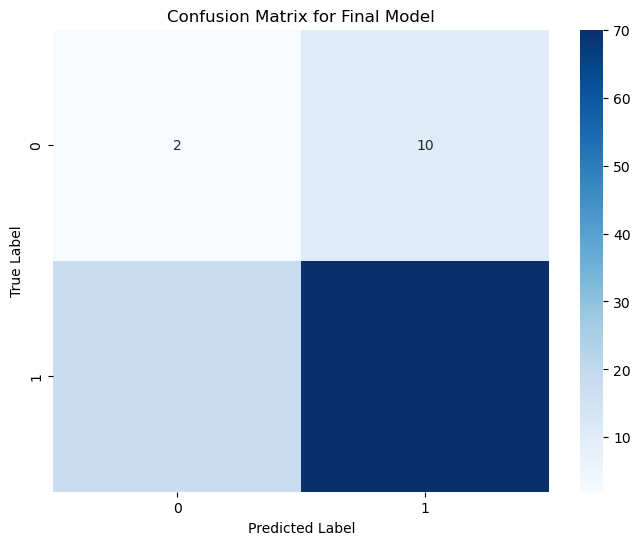

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix for Final Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Final K-fold model accuracy

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化模型参数
final_violation_model = DecisionTreeClassifier(
    **best_params,
    random_state=42
)

# K-Fold 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

print("K-Fold Cross-Validation for Final Model:")
for fold, (train_index, val_index) in enumerate(kf.split(X_full), 1):
    X_train, X_val = X_full.iloc[train_index], X_full.iloc[val_index]
    y_train, y_val = y_full.iloc[train_index], y_full.iloc[val_index]

    # 使用相同参数训练模型
    model = DecisionTreeClassifier(**best_params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)

    print(f" Fold {fold}: Accuracy = {acc:.4f}")

# 打印所有折的准确率
print("\nAll Fold Accuracies:", fold_accuracies)
print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f}")


K-Fold Cross-Validation for Final Model:
 Fold 1: Accuracy = 0.8075
 Fold 2: Accuracy = 0.7847
 Fold 3: Accuracy = 0.8071
 Fold 4: Accuracy = 0.8133
 Fold 5: Accuracy = 0.8050

All Fold Accuracies: [0.8074534161490683, 0.7846790890269151, 0.8070539419087137, 0.8132780082987552, 0.8049792531120332]

Average Accuracy: 0.8035


## Explainability

In [27]:
# Train the final model with best hyperparameters
final_violation_model = DecisionTreeClassifier(
    **best_params,
    random_state=42
)

final_violation_model.fit(X_full, y_full)

DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       random_state=42)

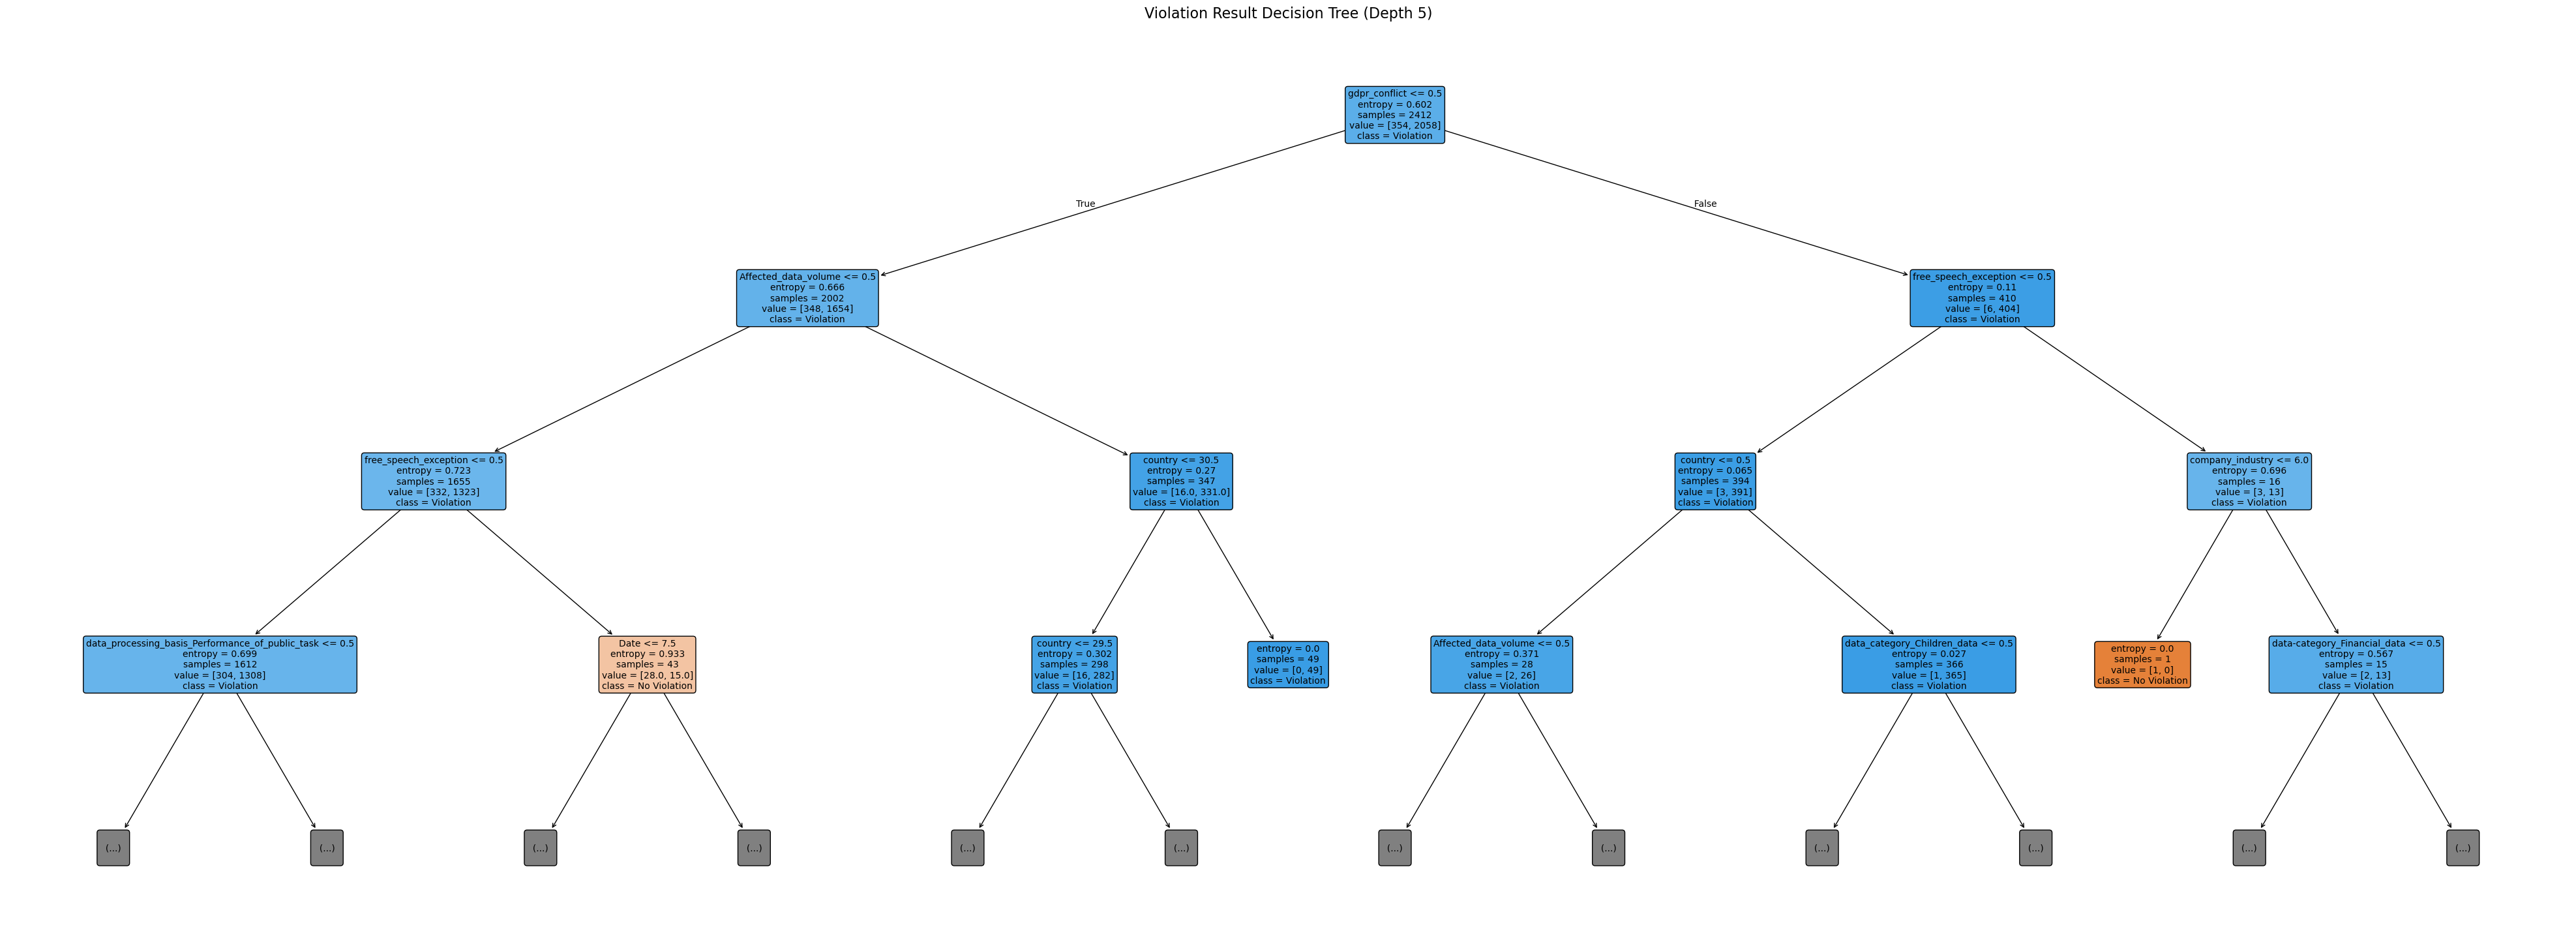

In [28]:
plt.figure(figsize=(40, 15))  # Larger image size to give the tree more space

plot_tree(final_violation_model, 
          feature_names=X_full.columns, 
          class_names=['No Violation', 'Violation'],
          filled=True, 
          rounded=True, 
          max_depth=3,
          fontsize=10)  # Removed unsupported 'orientation' parameter

plt.title('Violation Result Decision Tree (Depth 5)', fontsize=16)
plt.tight_layout(pad=2.5)  # Added more padding for spacing
plt.savefig('violation_tree_large.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
from sklearn.tree import export_text

# Limit maximum depth to avoid information overload (optional)
MAX_RULE_DEPTH = 5

# Output the decision tree text rules
print(f"\nViolation Result Decision Tree Rules (Max Depth {MAX_RULE_DEPTH}):\n")
tree_rules = export_text(
    decision_tree=final_violation_model,
    feature_names=list(X_full.columns),
    max_depth=MAX_RULE_DEPTH,
    decimals=3,  # Keep this many decimal places for cleaner output
    show_weights=True  # Optional, shows number of samples at each node
)
print(tree_rules)


Violation Result Decision Tree Rules (Max Depth 5):

|--- gdpr_conflict <= 0.500
|   |--- Affected_data_volume <= 0.500
|   |   |--- free_speech_exception <= 0.500
|   |   |   |--- data_processing_basis_Performance_of_public_task <= 0.500
|   |   |   |   |--- country <= 25.500
|   |   |   |   |   |--- data-category_Financial_data <= 0.500
|   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |--- data-category_Financial_data >  0.500
|   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |--- country >  25.500
|   |   |   |   |   |--- country <= 28.500
|   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- country >  28.500
|   |   |   |   |   |   |--- truncated branch of depth 21
|   |   |   |--- data_processing_basis_Performance_of_public_task >  0.500
|   |   |   |   |--- country <= 0.500
|   |   |   |   |   |--- data_category_Criminal_data <= 0.500
|   |   |   |   |   |   |--- truncated branch of depth 7
|   |  

## Case Study

In [30]:
def predict_single_case(sample_dict):
    import pandas as pd
    from sklearn.tree import _tree

    # 创建 DataFrame
    sample_df = pd.DataFrame([sample_dict])

    # 编码 categorical 特征（使用你训练时保存的 label_encoders）
    for col in sample_df.columns:
        if col in label_encoders:
            try:
                sample_df[col] = label_encoders[col].transform(sample_df[col])
            except ValueError as e:
                print(f"⚠️ Warning: Value '{sample_df[col].values[0]}' for column '{col}' not seen during training.")
                sample_df[col] = -1  # 或其他处理方式，比如填 0 或 NaN

    # One-hot 编码并对齐训练时的列
    sample_encoded = pd.get_dummies(sample_df)
    sample_aligned = sample_encoded.reindex(columns=X_full.columns, fill_value=0)

    # 模型预测
    prediction = final_violation_model.predict(sample_aligned)[0]
    print(f"\n🔎 Predicted Violation Result: {prediction}\n")

    # 获取决策路径
    tree_ = final_violation_model.tree_
    node_indicator = final_violation_model.decision_path(sample_aligned)
    leaf_id = final_violation_model.apply(sample_aligned)

    print(f"🧠 Decision Path to Leaf Node {leaf_id[0]}:\n")

    for node_id in node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]:
        if leaf_id[0] == node_id:
            print(f"→ Final decision made at leaf node {node_id}")
            continue

        feature_index = tree_.feature[node_id]
        threshold = tree_.threshold[node_id]
        value = sample_aligned.iloc[0, feature_index]
        feature_name = X_full.columns[feature_index]

        # 尝试解码值为人类可读的标签
        def inverse_label_value(feature_name, value):
            if feature_name in label_encoders:
                try:
                    return label_encoders[feature_name].inverse_transform([int(value)])[0]
                except (ValueError, IndexError):
                    return f"{value} (未知编码)"
            return value

        value_display = inverse_label_value(feature_name, value)
        # 显示 threshold（如果是整数编码，也尝试解码）
        if feature_name in label_encoders and threshold.is_integer():
            threshold_display = inverse_label_value(feature_name, int(threshold))
        else:
            threshold_display = f"{threshold:.4f}"

        condition = "<=" if value <= threshold else ">"
        print(f"Node {node_id}: ({feature_name} = {value_display}) {condition} {threshold_display}")


In [31]:
sample ={
    "data_category_Basic_personal_data": 0,
    "data_category_Special_category_data": 0,
    "data_category_Criminal_data": 0,
    "data_category_Financial_location_data": 0,
    "data_category_Children_data": 0,
    "data_processing_basis_Legitimate_interest": 0,
    "data_processing_basis_contract_performance": 1,
    "data_processing_basis_Consent": 1,
    "data_processing_basis_Legal_obligation": 1,
    "data_processing_basis_Protection_of_vital_interests": 1,
    "data_processing_basis_Performance_of_public_task": 1,
    "country": "Slovenia",
    "company_industry": "Human resources",
    "gdpr_conflict": "No conflict",
    "free_speech_exception": 0,
    "country_security_exception": 0,
    "Criminal_investigation_exception": 0,
    "Affected_data_volume": 556,
    "Date": "2020"
  }


predict_single_case(sample)


🔎 Predicted Violation Result: 1

🧠 Decision Path to Leaf Node 485:

Node 0: (gdpr_conflict = No conflict) <= 0.5000
Node 1: (Affected_data_volume = 556) > 0.5000
Node 481: (country = Slovenia) <= 30.5000
Node 482: (country = Slovenia) <= 29.5000
Node 483: (country = Slovenia) <= 23.5000
Node 484: (Date = 0) <= 4.5000
→ Final decision made at leaf node 485
